# Gene conversion tests

This is to see if gene conversion is happening across gene families 
For the gene conversions we have thought of 4 types of tests to try to establish Gene conversion. 
1. *GC3 content ~ copy number*<br>

2. *Pairwise differences according to location classification*. 

3. *Median % differences in gene family ~ copy number* <br>

4. *Pairwise % difference ~ distance* <br>

For this the following steps need to be performed:
1. Extract whole gene sequences for the genes and put them in the following structure:

 ```
sequences_x_full/
  ├── Family_A/
  │   ├── Cluster_1/
  │   │   ├── PanTro.fasta
  │   │   ├── HomSap.fasta
  │   │   └── ...
  │   └── Cluster_2/
  └── Family_B/
```



## All raw information 

In [ ]:
# Import all necessary libraries
import os
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

In [2]:
# ============================================
# Set base directories 
# ============================================

# Base directory where your data is stored
data_dir = "/home/emma/Amplicons/Workspaces/emma/downloaded_data"

# Output directory (will be created if it doesn't exist)
output_dir = os.path.join(data_dir, "sequences_x_full") # change according to chromosome

# Path to your gene_details table
# Change this to the actual location of your file!
gene_details_file = f"{data_dir}/sequences_x_updated/all_families_gene_details_with_clusters.tsv" 

# ============================================

print(f"✓ Data directory: {data_dir}")
print(f"✓ Output directory: {output_dir}")
print(f"✓ Gene details file: {gene_details_file}")

✓ Data directory: /home/emma/Amplicons/Workspaces/emma/downloaded_data
✓ Output directory: /home/emma/Amplicons/Workspaces/emma/downloaded_data/sequences_x_full
✓ Gene details file: /home/emma/Amplicons/Workspaces/emma/downloaded_data/sequences_x_updated/all_families_gene_details_with_clusters.tsv


In [ ]:
# Load the table
gene_details = pd.read_csv(gene_details_file, sep='\t')
gene_details

Loading gene details table...



,Species,Gene,Gene_symbol,Start,End,Strand,Class,gene_family_symbol,in_palindrome,palindrome_name,cluster
0,PanTro,colony stimulating factor 2 receptor subunit a...,LOC746936,1771418,1838874,+,PAR,CSF2RA,no,NaN,CSF2RA
1,PanTro,sperm protein associated with the nucleus on t...,LOC129388397,3486949,3488083,+,AMPLICONIC,SPANXA1,no,NaN,PanPan_PanTro_cluster1
2,PanTro,SPANX A/D member 3,LOC493983,3566190,3567169,+,AMPLICONIC,SPANXA1,no,NaN,PanPan_PanTro_cluster1
3,PanTro,protein kinase X-linked,PRKX,4149880,4259574,-,ANCESTRAL,TBL1X,no,NaN,PRKX
4,PanTro,atherin-like,LOC740134,4370640,4405131,-,ANCESTRAL,TBL1X,no,NaN,PanTro_cluster1
...,...,...,...,...,...,...,...,...,...,...,...
1697,MacFas,cancer/testis antigen 1-like,LOC102119988,160766910,160770217,+,Unknown,LAGE3,no,NaN,MacFas_cluster2
1698,MacFas,histone H2A-Bbd type 2/3-like,LOC123571317,161473449,161473969,+,Unknown,H2AB3,no,NaN,H2AB1
1699,MacFas,40-kDa huntingtin-associated protein,LOC135969152,161474855,161476570,+,Unknown,F8A2,no,NaN,F8A3
1700,MacFas,40-kDa huntingtin-associated protein,LOC123571316,161507913,161509975,-,Unknown,F8A2,no,NaN,MacFas_PonAbe_PonPyg_cluster1


## Extract gene sequences 

In [4]:
# Define all species and their reference genome locations
data = [
    {'species':'PanTro',
     'data': {'chr_x': "NC_072421.2",
              'fasta_x': f"{data_dir}/references/PanTro/ncbi_dataset/data/GCF_028858775.2/PanTro_X.fasta",
              'chr_y': "NC_072422.2",
              'fasta_y': f"{data_dir}/references/PanTro/ncbi_dataset/data/GCF_028858775.2/PanTro_Y.fasta"
     }},
    {'species':'HomSap',
     'data': {'chr_x': "NC_060947.1",
              'fasta_x': f"{data_dir}/references/HomSap/ncbi_dataset/data/GCF_009914755.1/HomSap_X.fasta",
              'chr_y': "NC_060948.1",
              'fasta_y': f"{data_dir}/references/HomSap/ncbi_dataset/data/GCF_009914755.1/HomSap_Y.fasta"
     }},
    {'species':'PanPan',
     'data': {'chr_x': "NC_073272.2",
              'fasta_x': f"{data_dir}/references/PanPan/ncbi_dataset/data/GCF_029289425.2/PanPan_X.fasta",
              'chr_y': "NC_073273.2",
              'fasta_y': f"{data_dir}/references/PanPan/ncbi_dataset/data/GCF_029289425.2/PanPan_Y.fasta"
     }},
    {'species':'GorGor',
     'data': {'chr_x': "NC_073247.2",
              'fasta_x': f"{data_dir}/references/GorGor/ncbi_dataset/data/GCF_029281585.2/GorGor_X.fasta",
              'chr_y': "NC_073248.2",
              'fasta_y': f"{data_dir}/references/GorGor/ncbi_dataset/data/GCF_029281585.2/GorGor_Y.fasta"
     }},
    {'species':'PonPyg',
     'data': {'chr_x': "NC_072396.2",
              'fasta_x': f"{data_dir}/references/PonPyg/ncbi_dataset/data/GCF_028885625.2/PonPyg_X.fasta",
              'chr_y': "NC_072397.2",
              'fasta_y': f"{data_dir}/references/PonPyg/ncbi_dataset/data/GCF_028885625.2/PonPyg_Y.fasta"
     }},
    {'species':'PonAbe',
     'data': {'chr_x': "NC_072008.2",
              'fasta_x': f"{data_dir}/references/PonAbe/ncbi_dataset/data/GCF_028885655.2/PonAbe_X.fasta",
              'chr_y': "NC_072009.2",
              'fasta_y': f"{data_dir}/references/PonAbe/ncbi_dataset/data/GCF_028885655.2/PonAbe_Y.fasta"
     }},
    {'species':'SymSyn',
     'data': {'chr_x': "NC_072447.2",
              'fasta_x': f"{data_dir}/references/SymSyn/ncbi_dataset/data/GCF_028878055.3/SymSyn_X.fasta",
              'chr_y': "NC_072448.2",
              'fasta_y': f"{data_dir}/references/SymSyn/ncbi_dataset/data/GCF_028878055.3/SymSyn_Y.fasta"
     }},
    {'species':'MacFas',
     'data': {'chr_x': "NC_088395.1",
              'fasta_x': f"{data_dir}/references/MacFas/ncbi_dataset/data/GCF_037993035.2/MacFas_X.fasta",
              'chr_y': "NC_132903.1",
              'fasta_y': f"{data_dir}/references/MacFas/ncbi_dataset/data/GCF_037993035.2/MacFas_Y.fasta"
     }}
]

species_dict = {d['species']: d['data'] for d in data}
species_list = list(species_dict.keys())

print(f"✓ Configured {len(species_list)} species:")
for sp in species_list:
    print(f"  - {sp}")

✓ Configured 8 species:
  - PanTro
  - HomSap
  - PanPan
  - GorGor
  - PonPyg
  - PonAbe
  - SymSyn
  - MacFas


In [ ]:
# load full chromosome
print("Loading chromosome X sequences...\n")

# Dictionary to store chromosome X sequences
chr_x_sequences = {}

# Load each species' chromosome X
for species in species_list:
    fasta_x_path = species_dict[species]['fasta_y'] # change to X or Y!
    
    # Check if file exists
    if not os.path.exists(fasta_x_path):
        print(f"  WARNING: File not found for {species}")
        print(f"    Expected: {fasta_x_path}\n")
        continue
    
    # Load the FASTA file
    with open(fasta_x_path, 'r') as handle:
        records = list(SeqIO.parse(handle, 'fasta'))
        if len(records) > 0:
            chr_x_sequences[species] = records[0].seq
            print(f" {species}: Loaded {len(records[0].seq):,} bp")
        else:
            print(f" {species}: No sequences found in file")

print(f"\n Successfully loaded {len(chr_x_sequences)} chromosome X sequences!")

Loading chromosome X sequences...

✓ PanTro: Loaded 36,447,294 bp
✓ HomSap: Loaded 62,460,029 bp
✓ PanPan: Loaded 46,954,669 bp
✓ GorGor: Loaded 67,405,748 bp
✓ PonPyg: Loaded 49,419,398 bp
✓ PonAbe: Loaded 67,827,326 bp
✓ SymSyn: Loaded 29,938,336 bp
✓ MacFas: Loaded 17,124,583 bp

✓ Successfully loaded 8 chromosome X sequences!


In [7]:
# Extract gene sequences
# skips clusters with only 1 gene 
print("=" * 70)
print("EXTRACTING GENE SEQUENCES")
print("=" * 70)
print()

# Create the main output directory
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}\n")

# Statistics tracking
total_extracted = 0
families_processed = set()
clusters_processed = set()

# Group genes by family and cluster
grouped = gene_details.groupby(['gene_family_symbol', 'cluster'])

# Process each family-cluster combination
for (family, cluster), group_df in grouped:
    families_processed.add(family)
    clusters_processed.add((family, cluster))
    
    # directory structure: sequences_x_full/Family/Cluster/
    family_dir = os.path.join(output_dir, str(family))
    cluster_dir = os.path.join(family_dir, str(cluster))
    os.makedirs(cluster_dir, exist_ok=True)
    
    print(f"\n{'─' * 70}")
    print(f"Family: {family} | Cluster: {cluster}")
    print(f"{'─' * 70}")
    print(f"Contains {len(group_df)} genes from {group_df['Species'].nunique()} species")
    
    # Process each species within this family-cluster
    for species, species_genes in group_df.groupby('Species'):
        
        # FILTER: Only process if this species has 2 or more genes in this cluster
        num_genes = len(species_genes)
        if num_genes < 2:
            print(f"  ⊗ {species}: Skipped (only {num_genes} gene - need 2+)")
            continue
        
        # Check  the chromosome sequence
        if species not in chr_x_sequences:
            print(f"  {species}: Skipped (no chromosome sequence)")
            continue
        
        chr_seq = chr_x_sequences[species]
        gene_records = []
        
        # Extract each gene for this species
        for idx, row in species_genes.iterrows():
            gene_symbol = row['Gene_symbol']
            start = int(row['Start'])      
            end = int(row['End'])
            strand = row['Strand']         
            
            # Convert to Python 0-based indexing
            start_idx = start - 1
            end_idx = end
            
            # Extract the sequence from the chromosome
            gene_seq = chr_seq[start_idx:end_idx]
            
            # Reverse complement for - strand
            if strand == '-':
                gene_seq = gene_seq.reverse_complement()
            
            # Create FASTA record 
            record = SeqRecord(
                gene_seq,
                id=gene_symbol,
                description=f"{species} | {gene_symbol} | {strand} strand | {start:,}-{end:,} | Family:{family} | Cluster:{cluster}"
            )
            
            gene_records.append(record)
            total_extracted += 1
        
        # Write all genes for this species to one FASTA file
        output_file = os.path.join(cluster_dir, f"{species}.fasta")
        with open(output_file, 'w') as out_handle:
            SeqIO.write(gene_records, out_handle, 'fasta')
        
        print(f"  ✓ {species}: {len(gene_records)} genes → {species}.fasta")

print(f"\n{'=' * 70}")
print("EXTRACTION COMPLETE!")
print(f"{'=' * 70}")

## Align all gene sequences per species 

In [ ]:
# List all families
print("Gene Families:")
for family in sorted(families_processed):
    print(f"  - {family}")

In [ ]:
# rename some folders so that they can be aligned via MAFFT (cannot handle spaces: add underscores)
# Path to the directory where your folders are
directory = f"{data_dir}/sequences_y_full"

for folder in os.listdir(directory):
    old_path = os.path.join(directory, folder)
    
    # Only rename if it's a directory and contains a space
    if os.path.isdir(old_path) and " " in folder:
        new_name = folder.replace(" ", "_")
        new_path = os.path.join(directory, new_name)
        os.rename(old_path, new_path)
        print(f"Renamed: {folder} -> {new_name}")

In [ ]:
## align the sequences in each FASTA file using MAFFT (multiple sequence alginmener). 

# Directory containing the extracted sequences
sequences_dir = os.path.join(data_dir, "sequences_y_full") # CHANGE TO X OR Y

# MAFFT parameters
# --maxiterate 1000: maximum number of iterative refinement iterations
# You can adjust these if needed
mafft_params = "--maxiterate 1000"

In [ ]:
# Find all .fasta files (skip already-aligned files)
fasta_files = []
for root, dirs, files in os.walk(sequences_dir):
    for file in files:
        if file.endswith('.fasta') and not file.endswith('_mafft.fa'):
            fasta_files.append(os.path.join(root, file))

# Sort for organized processing
fasta_files.sort()

print(f" Found {len(fasta_files)} FASTA files to align\n")

if len(fasta_files) == 0:
    print(" No FASTA files found!")
    print("Run the extraction script first.")
else:
    print("Sample files found:")
    for f in fasta_files[:5]:
        print(f"  - {os.path.relpath(f, sequences_dir)}")
    if len(fasta_files) > 5:
        print(f"  ... and {len(fasta_files) - 5} more")

In [ ]:
# Run MAFFT alignment
# if it stops somewhere it will skip all folders that already have an alignment
print("=" * 70)
print("RUNNING MAFFT ALIGNMENTS")
print("=" * 70)
print()

# Track statistics
successful_alignments = 0
failed_alignments = 0
skipped_alignments = 0

# Process each FASTA file
for i, fasta_file in enumerate(fasta_files, 1):
    # Get relative path for cleaner output
    rel_path = os.path.relpath(fasta_file, sequences_dir)
    
    # Create output filename (same directory, add _mafft.fa)
    base_name = fasta_file.replace('.fasta', '')
    output_file = f"{base_name}_mafft.fa"
    
    # Check if alignment already exists # then skip that one! 
    if os.path.exists(output_file):
        print(f"[{i}/{len(fasta_files)}] ⊗ SKIPPED (already exists): {rel_path}")
        skipped_alignments += 1
        continue
    
    print(f"[{i}/{len(fasta_files)}] Aligning: {rel_path}")
    
    # MAFFT command
    cmd = f"mafft {mafft_params} {fasta_file} > {output_file}"
    
    try:
        # Run MAFFT
        # capture_output=True prevents MAFFT messages 
        result = subprocess.run(
            cmd, 
            shell=True, 
            check=True,
            capture_output=True,
            text=True
        )
        
        print(f"              ✓ Aligned → {os.path.basename(output_file)}\n")
        successful_alignments += 1
        
    except subprocess.CalledProcessError as e:
        print(f"              ✗ FAILED: {e}")
        print(f"              Error: {e.stderr}\n")
        failed_alignments += 1

print("=" * 70)
print("ALIGNMENT COMPLETE!")
print("=" * 70)

## Calculate GC3 content in coding regions

In [ ]:
# Extract GC3 for every gene 
# loop through all families and clusters
# calculate GC3
# skip gaps or ambiguous sites for both GC3 count as total length 
# cluster count: count genes per species within each alignment file 

In [ ]:
# Configuration
# Storage for results
results = []

# Automatically find all fasta files matching the pattern
pattern = f"{data_dir}/sequences_y_updated/*/blastdb/cluster_alignments/*_cluster_*_NT.fa"
fasta_files = glob.glob(pattern)

print(f"Found {len(fasta_files)} alignment files")

# Process each fasta file
for fasta_file in fasta_files:
    # Extract family and cluster from filename
    filename = os.path.basename(fasta_file)
    # filename format: {family}_cluster_{cluster}_NT.fa
    parts = filename.replace("_NT.fa", "").split("_cluster_")
    family = parts[0]
    cluster = parts[1]
    
    print(f"Processing {family} cluster {cluster}")
    
    # Count genes per species in this cluster
    species_counts = {}
    
    # Process each sequence in the fasta file
    for record in SeqIO.parse(fasta_file, "fasta"):
        # Extract species name (everything after the last underscore)
        species = record.id.split("_")[-1]
        
        # Count this gene for the species
        species_counts[species] = species_counts.get(species, 0) + 1
        
        # Extract sequence
        sequence = str(record.seq).upper()
        
        # Calculate GC3 content
        gc3_count = 0
        total_codons = 0
        
        # Iterate through sequence in steps of 3 (codons)
        for i in range(0, len(sequence) - 2, 3):
            codon = sequence[i:i+3]
            
            # Skip codons with gaps or ambiguous bases
            if '-' in codon or 'N' in codon:
                continue
            
            # Check 3rd position (index 2 of the codon)
            third_position = codon[2]
            
            if third_position in ['G', 'C']:
                gc3_count += 1
            
            total_codons += 1
        
        # Calculate GC3 ratio
        gc3_ratio = gc3_count / total_codons if total_codons > 0 else 0
        
        # Store results
        results.append({
            'family': family,
            'cluster': cluster,
            'species': species,
            'cluster_count': species_counts[species],
            'gene': record.id,
            'gc3_content': gc3_count,
            'length_codons': total_codons,
            'gc3_ratio': gc3_ratio
        })

# Create DataFrame
df = pd.DataFrame(results)

# Display results
print(f"\nProcessed {len(df)} sequences")

Found 33 alignment files
Processing FRG1 cluster SymSyn_cluster1
Processing CDY1 cluster MacFas_cluster1
Processing CDY1 cluster CDY1
Processing CDY1 cluster PonAbe_cluster1
Processing isoenzyme cluster PonAbe_PonPyg_cluster2
Processing isoenzyme cluster PonAbe_PonPyg_cluster1
Processing isoenzyme cluster SymSyn_cluster1
Processing HSFY1 cluster GorGor_cluster1
Processing HSFY1 cluster PonPyg_cluster1
Processing HSFY1 cluster PonAbe_cluster1
Processing HSFY1 cluster HSFY2
Processing FAM47A cluster PonAbe_PonPyg_cluster1
Processing zinc cluster PonAbe_PonPyg_cluster1
Processing keratin cluster PanPan_cluster1
Processing retrovirus cluster PonAbe_PonPyg_cluster1
Processing glutamate cluster PonAbe_cluster1
Processing glutamate cluster PanTro_cluster1
Processing glutamate cluster PonAbe_PonPyg_cluster1
Processing centriole cluster GorGor_cluster1
Processing VCY1B cluster VCY
Processing VCY1B cluster PanPan_PanTro_cluster1
Processing RBMY1B cluster PanPan_PanTro_cluster1
Processing RBMY1B 

In [4]:
#df.to_csv(f"{data_dir}/sequences_x_full/sequences_x_full_gc3.csv", index=False)
df = pd.read_csv(f"{data_dir}/sequences_x_full/sequences_x_full_gc3.csv")
df

,family,cluster,species,cluster_count,gene,gc3_content,length_codons,gc3_ratio
0,H2A,H2AL1Q,PonPyg,1,LOC129024532_isoform_XP_054327622.1;protein_id...,122,178,0.685393
1,H2A,H2AL1Q,PanTro,1,H2AL1Q_isoform_XP_016798178.2;protein_id=XP_01...,144,205,0.702439
2,H2A,PonAbe_PonPyg_cluster1,PonAbe,1,LOC112130766_isoform_XP_024096332.2;protein_id...,114,154,0.740260
3,H2A,PonAbe_PonPyg_cluster1,PonPyg,1,LOC129024800_isoform_XP_054327986.1;protein_id...,114,154,0.740260
4,H2A,PonAbe_PonPyg_cluster1,PonAbe,2,LOC112130778_isoform_XP_024096410.2;protein_id...,114,154,0.740260
...,...,...,...,...,...,...,...,...
1555,OPN1LW,OPN1MW,MacFas,2,LOC135969085_isoform_XP_065393952.1;protein_id...,272,365,0.745205
1556,OPN1LW,OPN1MW,HomSap,3,OPN1LW_isoform_NP_064445.2;protein_id=NP_06444...,279,365,0.764384
1557,OPN1LW,OPN1MW,GorGor,2,OPN1LW_isoform_XP_030861761.2;protein_id=XP_03...,276,365,0.756164
1558,OPN1LW,OPN1MW,PonPyg,2,LOC129024452_isoform_XP_054327504.1;protein_id...,273,365,0.747945


In [35]:
# Create summary table
summary_df = df.groupby(['family', 'cluster', 'species']).agg({
    'gene': 'count',  # Copy number = count of genes
    'gc3_ratio': 'median'  # Median GC3 ratio
}).reset_index()

# Rename columns
summary_df.columns = ['family', 'cluster', 'species', 'copy_number', 'median_gc3_ratio']

# Display results
print(f"\nSummary table with {len(summary_df)} rows")
summary_df


Summary table with 856 rows


,family,cluster,species,copy_number,median_gc3_ratio
0,ARMCX,ARMCX1,GorGor,1,0.471366
1,ARMCX,ARMCX1,HomSap,1,0.471366
2,ARMCX,ARMCX1,MacFas,1,0.447137
3,ARMCX,ARMCX1,PanPan,1,0.473568
4,ARMCX,ARMCX1,PanTro,1,0.471366
...,...,...,...,...,...
851,ZXD,ZXDA,SymSyn,2,0.666047
852,collagen,HomSap_cluster1,HomSap,3,0.677346
853,endogenous,PanPan_PanTro_PonPyg_cluster1,PanPan,1,0.366237
854,endogenous,PanPan_PanTro_PonPyg_cluster1,PanTro,1,0.367143


#### Permutation of GC3~ copy copy number

In [ ]:
from scipy import stats

def permutation_test_gc3_per_family(summary_df, n_permutations=1000):
    """
    Perform permutation test for median GC3 ratio ~ copy number relationship per family
    
    Parameters:
    -----------
    summary_df : DataFrame
        The summary dataframe with columns: family, cluster, species, copy_number, median_gc3_ratio
    n_permutations : int
        Number of permutations to perform
    """
    
    # Storage for results
    results = []
    
    # Get unique families
    families = summary_df['family'].unique()
    
    for family in families:
        print(f"Testing {family}...")
        
        # Filter data for this family
        family_data = summary_df[summary_df['family'] == family].copy()
        
        # Convert to numeric and drop NA
        family_data['copy_number'] = pd.to_numeric(family_data['copy_number'], errors='coerce')
        family_data['median_gc3_ratio'] = pd.to_numeric(family_data['median_gc3_ratio'], errors='coerce')
        family_data = family_data.dropna(subset=['copy_number', 'median_gc3_ratio'])
        
        # Skip if too few data points
        if len(family_data) < 3:
            print(f"  Skipping {family} - too few data points ({len(family_data)})")
            continue
        
        # Get x and y values
        x_obs = family_data['copy_number'].values
        y_obs = family_data['median_gc3_ratio'].values
        
        # Check for no variation in x or y
        if len(np.unique(x_obs)) < 2:
            print(f"  Skipping {family} - no variation in copy number")
            continue
        
        if len(np.unique(y_obs)) < 2:
            print(f"  Skipping {family} - no variation in GC3 ratio")
            continue
        
        try:
            # Calculate observed slope
            slope_obs, intercept_obs, r_value, p_value_parametric, std_err = stats.linregress(x_obs, y_obs)
        except ValueError as e:
            print(f"  Skipping {family} - error in linear regression: {e}")
            continue
        
        # Permutation test
        permuted_slopes = []
        
        for i in range(n_permutations):
            # Permute the copy_number column (x values)
            x_perm = np.random.permutation(x_obs)
            
            try:
                # Calculate slope with permuted data
                slope_perm, _, _, _, _ = stats.linregress(x_perm, y_obs)
                permuted_slopes.append(slope_perm)
            except ValueError:
                # Skip this permutation if it fails
                continue
        
        # Skip if not enough successful permutations
        if len(permuted_slopes) < n_permutations * 0.9:  # At least 90% successful
            print(f"  Skipping {family} - too many failed permutations")
            continue
        
        # Calculate p-value
        permuted_slopes = np.array(permuted_slopes)
        
        if slope_obs >= 0:
            p_value = np.sum(permuted_slopes >= slope_obs) / len(permuted_slopes)
        else:
            p_value = np.sum(permuted_slopes <= slope_obs) / len(permuted_slopes)
        
        # Two-tailed p-value
        p_value_two_tailed = 2 * min(p_value, 1 - p_value)
        
        # Store results
        results.append({
            'family': family,
            'n_points': len(family_data),
            'observed_slope': slope_obs,
            'r_squared': r_value**2,
            'p_value_permutation': p_value_two_tailed,
            'p_value_parametric': p_value_parametric,
            'mean_permuted_slope': np.mean(permuted_slopes),
            'std_permuted_slope': np.std(permuted_slopes)
        })
        
        print(f"  N points: {len(family_data)}")
        print(f"  Observed slope: {slope_obs:.6f}")
        print(f"  P-value (permutation): {p_value_two_tailed:.4f}")
        print(f"  P-value (parametric): {p_value_parametric:.4f}")
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('p_value_permutation')
    
    return results_df

# Run permutation test for GC3 ~ copy number
print("=== GC3 ~ COPY NUMBER PERMUTATION TEST ===")
results_gc3 = permutation_test_gc3_per_family(summary_df, n_permutations=10000)

print("\n=== Results for GC3 ~ Copy Number ===")
#print(results_gc3)

=== GC3 ~ COPY NUMBER PERMUTATION TEST ===
Testing BPY2...
  N points: 4
  Observed slope: 0.004673
  P-value (permutation): 0.3288
  P-value (parametric): 0.1520
Testing CDY1...
  N points: 9
  Observed slope: -0.000427
  P-value (permutation): 0.4560
  P-value (parametric): 0.4582
Testing DAZ1...
  N points: 9
  Observed slope: 0.001245
  P-value (permutation): 0.6056
  P-value (parametric): 0.7696
Testing FAM47A...
  Skipping FAM47A - too few data points (2)
Testing FRG1...
  Skipping FRG1 - too few data points (1)
Testing HSFY1...
  N points: 8
  Observed slope: 0.005885
  P-value (permutation): 0.7230
  P-value (parametric): 0.4853
Testing MTRNR2...
  Skipping MTRNR2 - too few data points (1)
Testing RBMY1B...
  N points: 12
  Observed slope: -0.001506
  P-value (permutation): 0.3766
  P-value (parametric): 0.3684
Testing TATA-box...
  Skipping TATA-box - too few data points (1)
Testing TSPY8...
  N points: 9
  Observed slope: 0.000430
  P-value (permutation): 0.0710
  P-value (pa

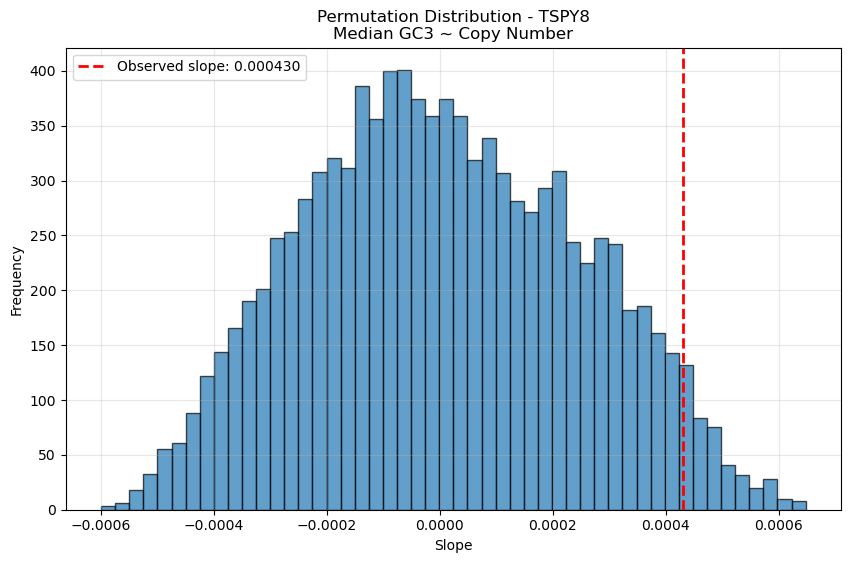

N points: 9
Observed slope: 0.000430
P-value: 0.0782


In [ ]:
def plot_gc3_permutation_distribution(family_name, summary_df, n_permutations=1000):
    """
    Plot the permutation distribution for GC3 ~ copy number in a specific family
    """
    # Filter for specific family
    family_data = summary_df[summary_df['family'] == family_name].copy()
    
    # Convert to numeric and drop NA
    family_data['copy_number'] = pd.to_numeric(family_data['copy_number'], errors='coerce')
    family_data['median_gc3_ratio'] = pd.to_numeric(family_data['median_gc3_ratio'], errors='coerce')
    family_data = family_data.dropna(subset=['copy_number', 'median_gc3_ratio'])
    
    # Get values
    x_obs = family_data['copy_number'].values
    y_obs = family_data['median_gc3_ratio'].values
    
    # Calculate observed slope
    slope_obs, _, _, _, _ = stats.linregress(x_obs, y_obs)
    
    # Permutation
    permuted_slopes = []
    for i in range(n_permutations):
        x_perm = np.random.permutation(x_obs)
        slope_perm, _, _, _, _ = stats.linregress(x_perm, y_obs)
        permuted_slopes.append(slope_perm)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.hist(permuted_slopes, bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(slope_obs, color='red', linestyle='--', linewidth=2, label=f'Observed slope: {slope_obs:.6f}')
    plt.xlabel('Slope')
    plt.ylabel('Frequency')
    plt.title(f'Permutation Distribution - {family_name}\nMedian GC3 ~ Copy Number')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate p-value
    if slope_obs >= 0:
        p_value = np.sum(np.array(permuted_slopes) >= slope_obs) / n_permutations
    else:
        p_value = np.sum(np.array(permuted_slopes) <= slope_obs) / n_permutations
    p_value_two_tailed = 2 * min(p_value, 1 - p_value)
    
    print(f"N points: {len(family_data)}")
    print(f"Observed slope: {slope_obs:.6f}")
    print(f"P-value: {p_value_two_tailed:.4f}")

# Example check per family:
plot_gc3_permutation_distribution("TSPY8", summary_df, n_permutations=10000)

In [94]:
results_gc3

,family,n_points,observed_slope,r_squared,p_value_permutation,p_value_parametric,mean_permuted_slope,std_permuted_slope
5,TSPY8,9,0.000430,0.402449,0.0710,0.066491,-1.124915e-06,0.000240
0,BPY2,4,0.004673,0.719077,0.3288,0.152016,5.661395e-07,0.003169
4,RBMY1B,12,-0.001506,0.081511,0.3766,0.368371,-7.753608e-06,0.001586
1,CDY1,9,-0.000427,0.080893,0.4560,0.458240,4.017211e-06,0.000530
7,isoenzyme,5,-0.011822,0.123628,0.6028,0.561723,-1.765064e-05,0.016883
2,DAZ1,9,0.001245,0.013073,0.6056,0.769600,1.642583e-05,0.003833
3,HSFY1,8,0.005885,0.084336,0.7230,0.485327,8.487700e-05,0.007650
6,glutamate,4,0.002743,0.001534,0.9756,0.960837,-8.292590e-04,0.040221


In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(readr)
library(ggplot2)
library(dplyr)
library(patchwork)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [17]:
%%R 
gc3_x <- read_csv("sequences_x_full/sequences_x_full_gc3.csv")
gc3_y <- read_csv("sequences_y_full/sequences_y_full_gc3.csv")

Rows: 1560 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): family, cluster, species, gene
dbl (4): cluster_count, gc3_content, length_codons, gc3_ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 385 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): family, cluster, species, gene
dbl (4): cluster_count, gc3_content, length_codons, gc3_ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
%%R
### PLOT 2 GC3 ~ copy number  ####
# Instead of creating summary_df, work directly with gc3_x
# Add copy number information to each gene
individual_df <- gc3_x %>%
  group_by(family, cluster, species) %>%
  mutate(copy_number = n()) %>%  # Add copy number as a column
  ungroup()

# Display results
print(paste("Individual data with", nrow(individual_df), "rows"))
print(head(individual_df))

# Select a specific family
specific_family <- "GAGE"  

# Filter data for that family & remove copy number 1 datapoints
family_data <- individual_df %>%
  filter(family == specific_family) %>%
  filter(copy_number > 1)  # Remove copy number = 1

# Create scatter plot with regression line
plot1 <- ggplot(family_data, aes(x = copy_number, y = gc3_ratio)) +
  geom_point(alpha = 0.6, size = 4, position = position_jitter(width = 0.4, height = 0))+  # Reduced alpha since there will be overlapping points
  geom_smooth(method = "lm", 
              formula = y ~ x,
              se = T,
              color = "#2E7DB8", 
              linetype = "dashed",
              linewidth = 1.4) +
  labs(
    x = "Copy Number",
    y = "GC3 Ratio"
  ) +
  theme_minimal() +
  theme(
    axis.title = element_text(),
    axis.title.y = element_text(size=22),
    axis.title.x = element_text(size = 22),
    axis.text.y = element_text(size = 18),
    axis.text.x = element_text(size = 18),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.line = element_line(color = "black", linewidth = 1)
  )

plot1


ggsave("sequences_x_full/GAGE_gene_conversion_GC3_copynumber.pdf", plot1, width = 10, height = 8, units = "in")

[1] "Individual data with 1560 rows"
# A tibble: 6 × 9
  family cluster species cluster_count gene  gc3_content length_codons gc3_ratio
  <chr>  <chr>   <chr>           <dbl> <chr>       <dbl>         <dbl>     <dbl>
1 H2A    H2AL1Q  PonPyg              1 LOC1…         122           178     0.685
2 H2A    H2AL1Q  PanTro              1 H2AL…         144           205     0.702
3 H2A    PonAbe… PonAbe              1 LOC1…         114           154     0.740
4 H2A    PonAbe… PonPyg              1 LOC1…         114           154     0.740
5 H2A    PonAbe… PonAbe              2 LOC1…         114           154     0.740
6 H2A    PonAbe… PonAbe              3 LOC1…         114           154     0.740
# ℹ 1 more variable: copy_number <int>


## Calculate pairwise differences in whole gene sequences 

In [ ]:
# This notebook performs pairwise analysis of gene sequences including:
# 1. Calculating pairwise differences with complete deletion
# 2. Palindrome relationship analysis
# 3. Copy number correlation analysis
# 4. Physical distance correlation analysis

In [ ]:
# Storage for pairwise results
pairwise_results = []

# Find all species-specific alignment files
pattern = f"{data_dir}/sequences_x_full/*/*/*.fa"
alignment_files = glob.glob(pattern)

print(f"Found {len(alignment_files)} species-specific alignment files")

# Process each alignment file
for alignment_file in alignment_files:
    # Extract family, cluster, and species from path
    # Path format: {data_dir}/sequences_y_full/{family}/{cluster}/{species}_mafft.fa
    path_parts = alignment_file.split(os.sep)
    species_filename = os.path.basename(alignment_file)
    species = species_filename.replace("_mafft.fa", "")
    cluster = path_parts[-2]
    family = path_parts[-3]
    
    print(f"Processing {family} - {cluster} - {species}")
    
    # Read all sequences from the alignment
    sequences = list(SeqIO.parse(alignment_file, "fasta"))
    copy_number = len(sequences)
    
    # Skip if only one or zero sequences
    if copy_number < 2:
        continue
    
    # Extract gene names and sequences
    gene_data = []
    for record in sequences:
        # Gene name is the first part before the space
        gene_name = record.id.split()[0]
        sequence = str(record.seq).upper()
        gene_data.append({'gene': gene_name, 'sequence': sequence})
    
    # Perform complete deletion - find positions without gaps in ANY sequence
    seq_length = len(gene_data[0]['sequence'])
    valid_positions = []
    
    for pos in range(seq_length):
        has_gap = False
        for gene_info in gene_data:
            if gene_info['sequence'][pos] == '-':
                has_gap = True
                break
        if not has_gap:
            valid_positions.append(pos)
    
    # Create cleaned sequences (only valid positions)
    for gene_info in gene_data:
        cleaned_seq = ''.join([gene_info['sequence'][pos] for pos in valid_positions])
        gene_info['cleaned_sequence'] = cleaned_seq
    
    cleaned_length = len(valid_positions)
    
    # Skip if no valid positions remain
    if cleaned_length == 0:
        continue
    
    # Calculate pairwise differences for all combinations
    for gene1_info, gene2_info in combinations(gene_data, 2):
        gene1 = gene1_info['gene']
        gene2 = gene2_info['gene']
        seq1 = gene1_info['cleaned_sequence']
        seq2 = gene2_info['cleaned_sequence']
        
        # Count differences
        differences = sum(1 for a, b in zip(seq1, seq2) if a != b)
        
        # Calculate percentage
        pairwise_diff_pct = (differences / cleaned_length) * 100 if cleaned_length > 0 else 0
        
        # Store results
        pairwise_results.append({
            'family': family,
            'cluster': cluster,
            'species': species,
            'copy_number': copy_number,
            'gene1': gene1,
            'gene2': gene2,
            'pairwise_difference': differences,
            'pairwise_diff_%': pairwise_diff_pct
        })

# Create DataFrame
pairwise_df = pd.DataFrame(pairwise_results)

# Display results
print(f"\nProcessed {len(pairwise_df)} pairwise comparisons")
#print(pairwise_df.head(20))

Found 337 species-specific alignment files
Processing VCX3A - PonAbe_PonPyg_cluster1 - PonAbe
Processing VCX3A - PonAbe_PonPyg_cluster1 - PonPyg
Processing VCX3A - VCX - PanPan
Processing VCX3A - VCX - PanTro
Processing VCX3A - VCX - SymSyn
Processing VCX3A - VCX - GorGor
Processing VCX3A - VCX - HomSap
Processing VCX3A - MacFas_cluster1 - MacFas
Processing TEX28 - TEX28 - PanTro
Processing TEX28 - TEX28 - PanPan
Processing TEX28 - TEX28 - MacFas
Processing TEX28 - TEX28 - PonPyg
Processing TEX28 - TEX28 - PonAbe
Processing TEX28 - TEX28 - SymSyn
Processing TEX28 - TEX28 - GorGor
Processing uncharacterized_LOC115932372 - GorGor_PonAbe_PonPyg_SymSyn_cluster1 - PonAbe
Processing uncharacterized_LOC115932372 - GorGor_PonAbe_PonPyg_SymSyn_cluster1 - PonPyg
Processing CT45A2 - CT45A3 - PanTro
Processing CT45A2 - CT45A3 - MacFas
Processing CT45A2 - CT45A3 - PanPan
Processing CT45A2 - CT45A3 - HomSap
Processing CT45A2 - CT45A3 - PonPyg
Processing CT45A2 - CT45A3 - SymSyn
Processing CT45A2 - C

In [ ]:
#pairwise_df.to_csv(f"{data_dir}/sequences_x_full/sequences_x_full_pairwise_diff.csv", index=False)
#pairwise_df = pd.read_csv(f"{data_dir}/sequences_x_full/sequences_x_full_pairwise_diff.csv")
#pairwise_df = pd.read_csv(f"{data_dir}/sequences_y_full/sequences_y_full_pairwise_diff.csv")
pairwise_df


,Species,Gene,Gene_symbol,Start,End,Strand,Class,gene_family_symbol,in_palindrome,palindrome_name,cluster
0,PanTro,colony stimulating factor 2 receptor subunit a...,LOC746936,1771418,1838874,+,PAR,CSF2RA,no,NaN,CSF2RA
1,PanTro,sperm protein associated with the nucleus on t...,LOC129388397,3486949,3488083,+,AMPLICONIC,SPANXA1,no,NaN,PanPan_PanTro_cluster1
2,PanTro,SPANX A/D member 3,LOC493983,3566190,3567169,+,AMPLICONIC,SPANXA1,no,NaN,PanPan_PanTro_cluster1
3,PanTro,protein kinase X-linked,PRKX,4149880,4259574,-,ANCESTRAL,TBL1X,no,NaN,PRKX
4,PanTro,atherin-like,LOC740134,4370640,4405131,-,ANCESTRAL,TBL1X,no,NaN,PanTro_cluster1
...,...,...,...,...,...,...,...,...,...,...,...
1697,MacFas,cancer/testis antigen 1-like,LOC102119988,160766910,160770217,+,Unknown,LAGE3,no,NaN,MacFas_cluster2
1698,MacFas,histone H2A-Bbd type 2/3-like,LOC123571317,161473449,161473969,+,Unknown,H2AB3,no,NaN,H2AB1
1699,MacFas,40-kDa huntingtin-associated protein,LOC135969152,161474855,161476570,+,Unknown,F8A2,no,NaN,F8A3
1700,MacFas,40-kDa huntingtin-associated protein,LOC123571316,161507913,161509975,-,Unknown,F8A2,no,NaN,MacFas_PonAbe_PonPyg_cluster1


In [ ]:
# add gene distance and palindrome information to the pairwise comparion
#gene_details =pd.read_csv(f"{data_dir}/sequences_x_updated/all_families_gene_details_with_clusters.tsv", sep='\t')  # Load gene_details with gene annotation

def calculate_absolute_distance(gene1_info, gene2_info):
    """Calculate absolute distance between gene midpoints in bp"""
    midpoint1 = (gene1_info['Start'] + gene1_info['End']) / 2
    midpoint2 = (gene2_info['Start'] + gene2_info['End']) / 2
    return abs(midpoint2 - midpoint1)


def determine_palindrome_relationship(pal1, pal_name1, pal2, pal_name2):
    """Determine the palindrome relationship between two genes"""
    # Neither in palindrome
    if pal1 == 'no' and pal2 == 'no':
        return 'neither_in_palindrome'
    
    # One in palindrome, one not
    if pal1 == 'no' or pal2 == 'no':
        return 'one_in_palindrome'
    
    # Both in palindromes
    if pal1 == 'yes' and pal2 == 'yes':
        # Extract palindrome base name (remove A/B suffix)
        base_name1 = pal_name1[:-1] if pal_name1[-1] in ['A', 'B'] else pal_name1
        base_name2 = pal_name2[:-1] if pal_name2[-1] in ['A', 'B'] else pal_name2
        
        # Check if same palindrome
        if base_name1 == base_name2:
            # Check if same arm or opposing arms
            if pal_name1 == pal_name2:
                return 'same_palindrome_same_arm'
            else:
                return 'same_palindrome_opposing_arms'
        else:
            return 'different_palindromes'
    
    return 'unknown'

# Add new columns to pairwise_df
pairwise_df['absolute_distance_bp'] = None
pairwise_df['palindrome_relationship'] = None

# Process each pairwise comparison
for idx, row in pairwise_df.iterrows():
    species = row['species']
    gene1 = row['gene1']
    gene2 = row['gene2']
    family = row['family']
    cluster = row['cluster']
    
    # Find gene1 in gene_details
    gene1_match = gene_details[(gene_details['Species'] == species) & 
                                (gene_details['Gene_symbol'] == gene1)]
    
    # Find gene2 in gene_details
    gene2_match = gene_details[(gene_details['Species'] == species) & 
                                (gene_details['Gene_symbol'] == gene2)]
    
    # Check if both genes were found
    if len(gene1_match) == 0 or len(gene2_match) == 0:
        continue
    
    gene1_info = gene1_match.iloc[0]
    gene2_info = gene2_match.iloc[0]
    
    # Calculate absolute distance
    abs_distance = calculate_absolute_distance(gene1_info, gene2_info)
    pairwise_df.at[idx, 'absolute_distance_bp'] = abs_distance
    
    # Find positions of gene1 and gene2
    gene1_pos = cluster_genes[cluster_genes['Gene_symbol'] == gene1]['position'].values
    gene2_pos = cluster_genes[cluster_genes['Gene_symbol'] == gene2]['position'].values
    
    if len(gene1_pos) > 0 and len(gene2_pos) > 0:
        rel_distance = calculate_relative_distance(gene1_pos[0], gene2_pos[0])
        pairwise_df.at[idx, 'relative_distance'] = rel_distance
    
    # Determine palindrome relationship
    pal1 = gene1_info['in_palindrome']
    pal_name1 = gene1_info['palindrome_name']
    pal2 = gene2_info['in_palindrome']
    pal_name2 = gene2_info['palindrome_name']
    
    pal_relationship = determine_palindrome_relationship(pal1, pal_name1, pal2, pal_name2)
    pairwise_df.at[idx, 'palindrome_relationship'] = pal_relationship

# Display results
print("\nUpdated pairwise_df with gene information:")
print(pairwise_df.head(20))
print(f"\nPalindrome relationship counts:")
print(pairwise_df['palindrome_relationship'].value_counts())


Updated pairwise_df with gene information:
   family                 cluster species  copy_number         gene1  \
0   VCX3A  PonAbe_PonPyg_cluster1  PonAbe            7  LOC134102853   
1   VCX3A  PonAbe_PonPyg_cluster1  PonAbe            7  LOC134102853   
2   VCX3A  PonAbe_PonPyg_cluster1  PonAbe            7  LOC134102853   
3   VCX3A  PonAbe_PonPyg_cluster1  PonAbe            7  LOC134102853   
4   VCX3A  PonAbe_PonPyg_cluster1  PonAbe            7  LOC134102853   
5   VCX3A  PonAbe_PonPyg_cluster1  PonAbe            7  LOC134102853   
6   VCX3A  PonAbe_PonPyg_cluster1  PonAbe            7  LOC100437634   
7   VCX3A  PonAbe_PonPyg_cluster1  PonAbe            7  LOC100437634   
8   VCX3A  PonAbe_PonPyg_cluster1  PonAbe            7  LOC100437634   
9   VCX3A  PonAbe_PonPyg_cluster1  PonAbe            7  LOC100437634   
10  VCX3A  PonAbe_PonPyg_cluster1  PonAbe            7  LOC100437634   
11  VCX3A  PonAbe_PonPyg_cluster1  PonAbe            7  LOC100439576   
12  VCX3A  PonAbe_Po

In [38]:
pairwise_df

,family,cluster,species,copy_number,gene1,gene2,pairwise_difference,pairwise_diff_%,absolute_distance_bp,relative_distance,palindrome_relationship
0,VCX3A,PonAbe_PonPyg_cluster1,PonAbe,7,LOC134102853,LOC100437634,11,1.632047,4997.0,1,neither_in_palindrome
1,VCX3A,PonAbe_PonPyg_cluster1,PonAbe,7,LOC134102853,LOC100439576,6,0.890208,1278931.0,2,neither_in_palindrome
2,VCX3A,PonAbe_PonPyg_cluster1,PonAbe,7,LOC134102853,LOC103889008,15,2.225519,1295591.5,3,neither_in_palindrome
3,VCX3A,PonAbe_PonPyg_cluster1,PonAbe,7,LOC134102853,LOC100937424,5,0.741840,1642896.0,4,neither_in_palindrome
4,VCX3A,PonAbe_PonPyg_cluster1,PonAbe,7,LOC134102853,LOC100440314,9,1.335312,1947387.0,5,neither_in_palindrome
...,...,...,...,...,...,...,...,...,...,...,...
2028,NXF3,NXF2,PanPan,4,LOC129395341,LOC129395270,532,5.901276,579024.5,None,one_in_palindrome
2029,NXF3,NXF2,PanPan,4,LOC129395341,LOC100985902,1812,20.099834,744989.0,None,neither_in_palindrome
2030,NXF3,NXF2,PanPan,4,LOC100978865,LOC129395270,0,0.000000,120457.5,1,same_palindrome_opposing_arms
2031,NXF3,NXF2,PanPan,4,LOC100978865,LOC100985902,1774,19.678314,286422.0,None,one_in_palindrome


In [ ]:
# save 
#pairwise_df.to_csv(f"{data_dir}/sequences_x_full/sequences_x_full_pairwise_diff.csv", index=False)
#pairwise_df_.to_csv(f"{data_dir}/sequences_y_full/sequences_y_full_pairwise_diff.csv", index=False)


##### Run permutation for every gene family for pairwise differences ~ # copies


In [ ]:
from scipy import stats

def permutation_test_per_family(pairwise_df, n_permutations=10000):
    """
    Perform permutation test for median pairwise diff % ~ copy number relationship per family
    """
    
    # create the family_species_stats dataframe 
    family_species_stats = pairwise_df.groupby(['family', 'species', 'cluster']).agg({
        'pairwise_diff_%': 'median',
        'copy_number': 'first'
    }).reset_index()
    family_species_stats.columns = ['family', 'species', 'cluster', 'median_pairwise_diff_%', 'copy_number']
    
    # Storage for results
    results = []
    
    # Get unique families
    families = family_species_stats['family'].unique()
    
    for family in families:
        print(f"Testing {family}...")
        
        # Filter data for this family
        family_data = family_species_stats[family_species_stats['family'] == family].copy()
        
        # Skip if too few data points -> then the analysis is not possible
        if len(family_data) < 3:
            print(f"  Skipping {family} - too few data points")
            continue
        
        # Get x and y values
        x_obs = family_data['copy_number'].values
        y_obs = family_data['median_pairwise_diff_%'].values
        
        # Check for no variation in x or y
        if len(np.unique(x_obs)) < 2:
            print(f"  Skipping {family} - no variation in copy number")
            continue
        
        if len(np.unique(y_obs)) < 2:
            print(f"  Skipping {family} - no variation in pairwise difference")
            continue
        
        try:
            # Calculate observed slope
            slope_obs, intercept_obs, r_value, p_value_parametric, std_err = stats.linregress(x_obs, y_obs)
        except ValueError as e:
            print(f"  Skipping {family} - error in linear regression: {e}")
            continue
        
        # Permutation test
        permuted_slopes = []
        
        for i in range(n_permutations):
            # Permute the copy_number column (x values)
            x_perm = np.random.permutation(x_obs)
            
            try:
                # Calculate slope with permuted data
                slope_perm, _, _, _, _ = stats.linregress(x_perm, y_obs)
                permuted_slopes.append(slope_perm)
            except ValueError:
                # Skip this permutation if it fails
                continue
        
        # Skip if not enough successful permutations
        if len(permuted_slopes) < n_permutations * 0.9:  # At least 90% successful
            print(f"  Skipping {family} - too many failed permutations")
            continue
        
        # Calculate p-value
        permuted_slopes = np.array(permuted_slopes)
        
        if slope_obs >= 0:
            p_value = np.sum(permuted_slopes >= slope_obs) / len(permuted_slopes)
        else:
            p_value = np.sum(permuted_slopes <= slope_obs) / len(permuted_slopes)
        
        # Two-tailed p-value
        p_value_two_tailed = 2 * min(p_value, 1 - p_value)
        
        # Store results
        results.append({
            'family': family,
            'n_points': len(family_data),
            'observed_slope': slope_obs,
            'r_squared': r_value**2,
            'p_value_permutation': p_value_two_tailed,
            'p_value_parametric': p_value_parametric,
            'mean_permuted_slope': np.mean(permuted_slopes),
            'std_permuted_slope': np.std(permuted_slopes)
        })
        
        print(f"  Observed slope: {slope_obs:.4f}")
        print(f"  P-value (permutation): {p_value_two_tailed:.4f}")
        print(f"  P-value (parametric): {p_value_parametric:.4f}")
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('p_value_permutation')
    
    return results_df

# Run the permutation test
results_df = permutation_test_per_family(pairwise_df, n_permutations=1000)

# Display results
print("\nPermutation test results:")
print(results_df)

Testing BPY2...
  Observed slope: 0.0108
  P-value (permutation): 0.6960
  P-value (parametric): 0.5790
Testing CDY1...
  Observed slope: 0.1594
  P-value (permutation): 0.0180
  P-value (parametric): 0.0019
Testing DAZ1...
  Observed slope: -0.8128
  P-value (permutation): 0.3400
  P-value (parametric): 0.4508
Testing HSFY1...
  Observed slope: -0.1973
  P-value (permutation): 0.8900
  P-value (parametric): 0.8564
Testing MTRNR2-like_17...
  Skipping MTRNR2-like_17 - too few data points
Testing RBMY1B...
  Observed slope: -0.0802
  P-value (permutation): 0.6760
  P-value (parametric): 0.6520
Testing TATA-box_binding_protein_associated_factor_11_like_protein_2-like...
  Skipping TATA-box_binding_protein_associated_factor_11_like_protein_2-like - too few data points
Testing TSPY8...
  Observed slope: 0.0040
  P-value (permutation): 0.0180
  P-value (parametric): 0.0191
Testing VCY1B...
  Skipping VCY1B - no variation in copy number
Testing adenylate_kinase_isoenzyme_6-like...
  Observed

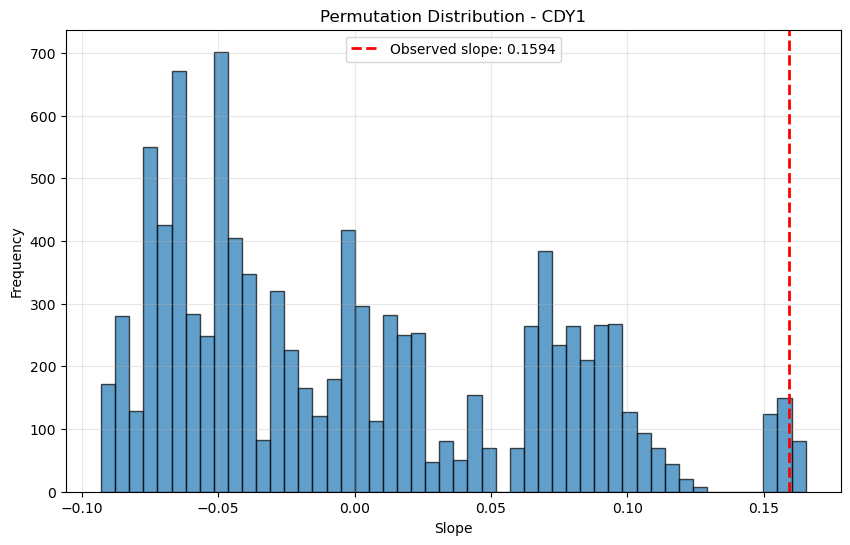

Observed slope: 0.1594
P-value: 0.0308


In [ ]:
# Visualize permutation distribution for a specific family
def plot_permutation_distribution(family_name, pairwise_df, n_permutations=10000):
    """
    Plot the permutation distribution for a specific family
    """
    # Create family_species_stats
    family_species_stats = pairwise_df.groupby(['family', 'species', 'cluster']).agg({
        'pairwise_diff_%': 'median',
        'copy_number': 'first'
    }).reset_index()
    family_species_stats.columns = ['family', 'species', 'cluster', 'median_pairwise_diff_%', 'copy_number']
    
    # Filter for specific family
    family_data = family_species_stats[family_species_stats['family'] == family_name].copy()
    
    # Calculate observed slope
    x_obs = family_data['copy_number'].values
    y_obs = family_data['median_pairwise_diff_%'].values
    slope_obs, _, _, _, _ = stats.linregress(x_obs, y_obs)
    
    # Permutation
    permuted_slopes = []
    for i in range(n_permutations):
        x_perm = np.random.permutation(x_obs)
        slope_perm, _, _, _, _ = stats.linregress(x_perm, y_obs)
        permuted_slopes.append(slope_perm)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.hist(permuted_slopes, bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(slope_obs, color='red', linestyle='--', linewidth=2, label=f'Observed slope: {slope_obs:.4f}')
    plt.xlabel('Slope')
    plt.ylabel('Frequency')
    plt.title(f'Permutation Distribution - {family_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate p-value
    if slope_obs >= 0:
        p_value = np.sum(np.array(permuted_slopes) >= slope_obs) / n_permutations
    else:
        p_value = np.sum(np.array(permuted_slopes) <= slope_obs) / n_permutations
    p_value_two_tailed = 2 * min(p_value, 1 - p_value)
    
    print(f"Observed slope: {slope_obs:.4f}")
    print(f"P-value: {p_value_two_tailed:.4f}")

# Example usage:
plot_permutation_distribution("CDY1", pairwise_df, n_permutations=10000)

##### Run permutation for every gene family for pairwise differences ~ distance


In [ ]:
from scipy import stats

def permutation_test_distance_per_family(pairwise_df, n_permutations=10000, distance_type='absolute'):
    """
    Perform permutation test for pairwise diff % ~ distance relationship per family
    
    Parameters:
    -----------
    pairwise_df : DataFrame
        The pairwise comparison dataframe
    n_permutations : int
        Number of permutations to perform
    distance_type : str
        Either 'absolute' for absolute_distance_bp or 'relative' for relative_distance
    """
    
    # Select the distance column
    if distance_type == 'absolute':
        distance_col = 'absolute_distance_bp'
        distance_label = 'Absolute Distance (bp)'
    elif distance_type == 'relative':
        distance_col = 'relative_distance'
        distance_label = 'Relative Distance'
    else:
        raise ValueError("distance_type must be 'absolute' or 'relative'")
    
    # Storage for results
    results = []
    
    # Get unique families
    families = pairwise_df['family'].unique()
    
    for family in families:
        print(f"Testing {family}...")
        
        # Filter data for this family
        family_data = pairwise_df[pairwise_df['family'] == family].copy()
        
        # Convert to numeric and drop NA
        family_data[distance_col] = pd.to_numeric(family_data[distance_col], errors='coerce')
        family_data['pairwise_diff_%'] = pd.to_numeric(family_data['pairwise_diff_%'], errors='coerce')
        family_data = family_data.dropna(subset=[distance_col, 'pairwise_diff_%'])
        
        # Skip if too few data points
        if len(family_data) < 3:
            print(f"  Skipping {family} - too few data points ({len(family_data)})")
            continue
        
        # Get x and y values
        x_obs = family_data[distance_col].values
        y_obs = family_data['pairwise_diff_%'].values
        
        # Check for no variation in x or y
        if len(np.unique(x_obs)) < 2:
            print(f"  Skipping {family} - no variation in distance")
            continue
        
        if len(np.unique(y_obs)) < 2:
            print(f"  Skipping {family} - no variation in pairwise difference")
            continue
        
        try:
            # Calculate observed slope
            slope_obs, intercept_obs, r_value, p_value_parametric, std_err = stats.linregress(x_obs, y_obs)
        except ValueError as e:
            print(f"  Skipping {family} - error in linear regression: {e}")
            continue
        
        # Permutation test
        permuted_slopes = []
        
        for i in range(n_permutations):
            # Permute the distance column (x values)
            x_perm = np.random.permutation(x_obs)
            
            try:
                # Calculate slope with permuted data
                slope_perm, _, _, _, _ = stats.linregress(x_perm, y_obs)
                permuted_slopes.append(slope_perm)
            except ValueError:
                # Skip this permutation if it fails
                continue
        
        # Skip if not enough successful permutations
        if len(permuted_slopes) < n_permutations * 0.9:  # At least 90% successful
            print(f"  Skipping {family} - too many failed permutations")
            continue
        
        # Calculate p-value
        permuted_slopes = np.array(permuted_slopes)
        
        if slope_obs >= 0:
            p_value = np.sum(permuted_slopes >= slope_obs) / len(permuted_slopes)
        else:
            p_value = np.sum(permuted_slopes <= slope_obs) / len(permuted_slopes)
        
        # Two-tailed p-value
        p_value_two_tailed = 2 * min(p_value, 1 - p_value)
        
        # Store results
        results.append({
            'family': family,
            'n_comparisons': len(family_data),
            'distance_type': distance_type,
            'observed_slope': slope_obs,
            'r_squared': r_value**2,
            'p_value_permutation': p_value_two_tailed,
            'p_value_parametric': p_value_parametric,
            'mean_permuted_slope': np.mean(permuted_slopes),
            'std_permuted_slope': np.std(permuted_slopes)
        })
        
        print(f"  N comparisons: {len(family_data)}")
        print(f"  Observed slope: {slope_obs:.6f}")
        print(f"  P-value (permutation): {p_value_two_tailed:.4f}")
        print(f"  P-value (parametric): {p_value_parametric:.4f}")
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('p_value_permutation')
    
    return results_df

# Run permutation test for absolute distance
print("=== ABSOLUTE DISTANCE PERMUTATION TEST ===")
results_absolute = permutation_test_distance_per_family(pairwise_df, n_permutations=1000, distance_type='absolute')

print("\n=== Results for Absolute Distance ===")
print(results_absolute)

# Run permutation test for relative distance
print("\n\n=== RELATIVE DISTANCE PERMUTATION TEST ===")
results_relative = permutation_test_distance_per_family(pairwise_df, n_permutations=1000, distance_type='relative')

print("\n=== Results for Relative Distance ===")
print(results_relative)

=== ABSOLUTE DISTANCE PERMUTATION TEST ===
Testing RBMY1B...
  N comparisons: 439
  Observed slope: -0.000000
  P-value (permutation): 0.8800
  P-value (parametric): 0.9138
Testing protein_FAM47A-like...
  Skipping protein_FAM47A-like - too few data points (2)
Testing proline-rich_protein,_Y-linked...
  Skipping proline-rich_protein,_Y-linked - no variation in pairwise difference
Testing keratin,_type_I_cytoskeletal_18-like...
  Skipping keratin,_type_I_cytoskeletal_18-like - too few data points (1)
Testing TSPY8...
  N comparisons: 1774
  Observed slope: 0.000000
  P-value (permutation): 0.0100
  P-value (parametric): 0.0010
Testing centriole_and_centriolar_satellite_protein_OFD1-like...
  Skipping centriole_and_centriolar_satellite_protein_OFD1-like - too few data points (1)
Testing HSFY1...
  N comparisons: 42
  Observed slope: -0.000000
  P-value (permutation): 0.9100
  P-value (parametric): 0.8154
Testing TATA-box_binding_protein_associated_factor_11_like_protein_2-like...
  Skipp

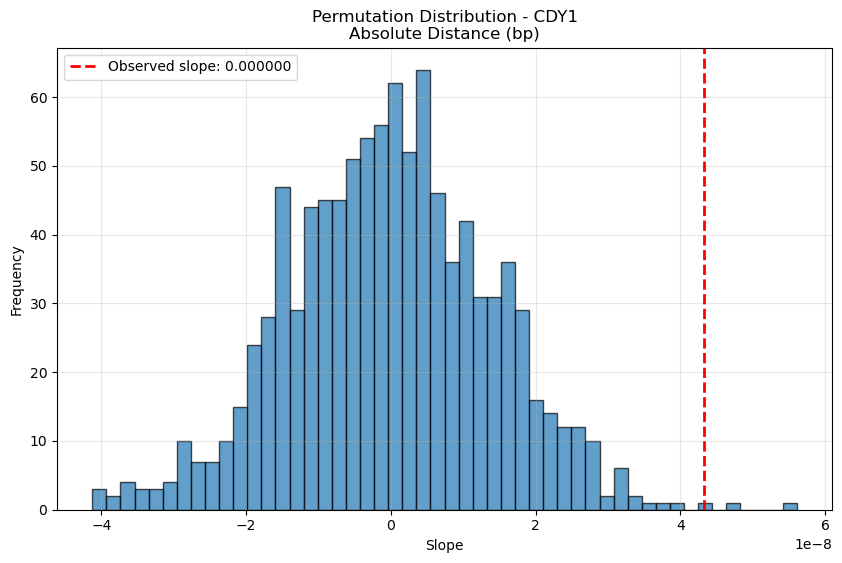

N comparisons: 281
Observed slope: 0.000000
P-value: 0.0040


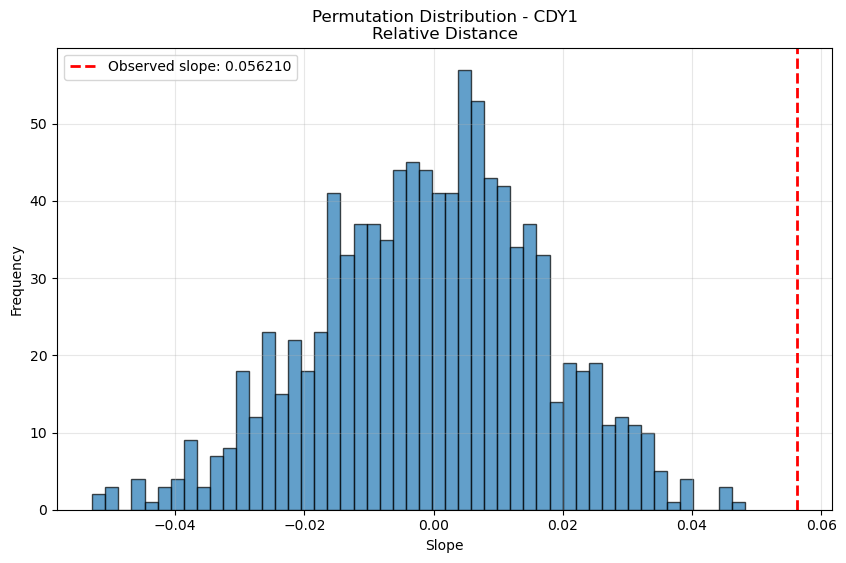

N comparisons: 281
Observed slope: 0.056210
P-value: 0.0000


In [ ]:
def plot_distance_permutation_distribution(family_name, pairwise_df, distance_type='absolute', n_permutations=10000):
    """
    Plot the permutation distribution for distance relationship in a specific family
    """
    # Select distance column
    if distance_type == 'absolute':
        distance_col = 'absolute_distance_bp'
        distance_label = 'Absolute Distance (bp)'
    else:
        distance_col = 'relative_distance'
        distance_label = 'Relative Distance'
    
    # Filter for specific family
    family_data = pairwise_df[pairwise_df['family'] == family_name].copy()
    
    # Convert to numeric and drop NA
    family_data[distance_col] = pd.to_numeric(family_data[distance_col], errors='coerce')
    family_data['pairwise_diff_%'] = pd.to_numeric(family_data['pairwise_diff_%'], errors='coerce')
    family_data = family_data.dropna(subset=[distance_col, 'pairwise_diff_%'])
    
    # Get values
    x_obs = family_data[distance_col].values
    y_obs = family_data['pairwise_diff_%'].values
    
    # Calculate observed slope
    slope_obs, _, _, _, _ = stats.linregress(x_obs, y_obs)
    
    # Permutation
    permuted_slopes = []
    for i in range(n_permutations):
        x_perm = np.random.permutation(x_obs)
        slope_perm, _, _, _, _ = stats.linregress(x_perm, y_obs)
        permuted_slopes.append(slope_perm)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.hist(permuted_slopes, bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(slope_obs, color='red', linestyle='--', linewidth=2, label=f'Observed slope: {slope_obs:.6f}')
    plt.xlabel('Slope')
    plt.ylabel('Frequency')
    plt.title(f'Permutation Distribution - {family_name}\n{distance_label}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate p-value
    if slope_obs >= 0:
        p_value = np.sum(np.array(permuted_slopes) >= slope_obs) / n_permutations
    else:
        p_value = np.sum(np.array(permuted_slopes) <= slope_obs) / n_permutations
    p_value_two_tailed = 2 * min(p_value, 1 - p_value)
    
    print(f"N comparisons: {len(family_data)}")
    print(f"Observed slope: {slope_obs:.6f}")
    print(f"P-value: {p_value_two_tailed:.4f}")

# Example:
plot_distance_permutation_distribution("CDY1", pairwise_df, distance_type='absolute', n_permutations=1000)

### Make a summary table of the 4 tests


In [ ]:
def create_summary_table_with_mapping(results_gc3, results_pairwise_copies, results_absolute, results_relative, family_mapping):
    """
    Create a summary table combining all four permutation test results per family
    with family name mapping
    
    Parameters:
    -----------
    results_gc3 : DataFrame
        Results from GC3 ~ copy number test
    results_pairwise_copies : DataFrame
        Results from median pairwise diff ~ copy number test
    results_absolute : DataFrame
        Results from pairwise diff ~ absolute distance test
    family_mapping : dict
        Dictionary mapping pairwise family names to GC3 family names

    Returns:
    --------
    DataFrame with columns for each test's slope and p-value
    """
    
    # Get all unique families from pairwise tests (these are the more specific names)
    all_families = set()
    all_families.update(results_pairwise_copies['family'].unique())
    all_families.update(results_absolute['family'].unique())
    
    # Create summary rows
    summary_rows = []
    
    for family in sorted(all_families):
        row = {'family': family}
        
        # Map to GC3 family name if mapping exists
        gc3_family = family_mapping.get(family, family)  # Use original name if no mapping
        
        # GC3 ~ copy number (use mapped family name)
        gc3_data = results_gc3[results_gc3['family'] == gc3_family]
        if len(gc3_data) > 0:
            row['gc3_slope'] = gc3_data.iloc[0]['observed_slope']
            row['gc3_pval'] = gc3_data.iloc[0]['p_value_permutation']
            row['gc3_n'] = gc3_data.iloc[0]['n_points']
            row['gc3_family_name'] = gc3_family  # Track which GC3 family was used
        else:
            row['gc3_slope'] = None
            row['gc3_pval'] = None
            row['gc3_n'] = None
            row['gc3_family_name'] = None
        
        # Median pairwise diff ~ copy number (use original family name)
        pairwise_copies_data = results_pairwise_copies[results_pairwise_copies['family'] == family]
        if len(pairwise_copies_data) > 0:
            row['pairwise_copies_slope'] = pairwise_copies_data.iloc[0]['observed_slope']
            row['pairwise_copies_pval'] = pairwise_copies_data.iloc[0]['p_value_permutation']
            row['pairwise_copies_n'] = pairwise_copies_data.iloc[0]['n_points']
        else:
            row['pairwise_copies_slope'] = None
            row['pairwise_copies_pval'] = None
            row['pairwise_copies_n'] = None
        
        # Pairwise diff ~ absolute distance (use original family name)
        absolute_data = results_absolute[results_absolute['family'] == family]
        if len(absolute_data) > 0:
            row['absolute_dist_slope'] = absolute_data.iloc[0]['observed_slope']
            row['absolute_dist_pval'] = absolute_data.iloc[0]['p_value_permutation']
            row['absolute_dist_n'] = absolute_data.iloc[0]['n_comparisons']
        else:
            row['absolute_dist_slope'] = None
            row['absolute_dist_pval'] = None
            row['absolute_dist_n'] = None
        
        
        summary_rows.append(row)
    
    # Create DataFrame
    summary_table = pd.DataFrame(summary_rows)
    
    # Reorder columns for clarity
    column_order = [
        'family',
        'gc3_family_name',
        'gc3_slope', 'gc3_pval', 'gc3_n',
        'pairwise_copies_slope', 'pairwise_copies_pval', 'pairwise_copies_n',
        'absolute_dist_slope', 'absolute_dist_pval', 'absolute_dist_n']
    
    summary_table = summary_table[column_order]
    
    return summary_table

# Define  family mapping dictionary
# family_mapping = {
#     'CENPVL2': 'CENPVL',
#     'CSAG2': 'CSAG',
#     'CSF2RA': 'CSF2RA',
#     'CT45A2': 'CT45A',
#     'CT47C1': 'CT47',
#     'CXorf49': 'CXorf49',
#     'CXorf51A': 'CXorf51',
#     'DMRTC1B': 'DMRTC1',
#     'EOLA1': 'EOLA',
#     'ETDB': 'ETD',
#     'F8A1': 'F8A1',
#     'FAM156A': 'FAM156',
#     'FAM236C': 'FAM236',
#     'GAGE12F': 'GAGE',
#     'GPRASP2': 'GPRASP',
#     'H2AB2': 'H2A',
#     'H2BW1': 'H2BW',
#     'HSFX2': 'HSFX',
#     'HSFX4': 'HSFX',
#     'IKBKG': 'IKBKG',
#     'INTS6L': 'INTS6L',
#     'LAGE3': 'LAGE3',
#     'MAGEB16': 'MAGEB',
#     'NUDT10': 'NUDT10',
#     'NXF3': 'NXF',
#     'OPN1LW': 'OPN1LW',
#     'PABPC1L2B': 'PABPC',
#     'PNMA6A': 'PNMA',
#     'PWWP4': 'PWWP4',
#     'RAB40A': 'RAB40A',
#     'RHOXF2': 'RHOXF2',
#     'RPL36A': 'RPL36A',
#     'RPL36A': 'RPL36A',
#     'SPACA5': 'SPACA5',
#     'SPANXA1': 'SPANX',
#     'SPIN4': 'SPIN',
#     'SSX4': 'SSX',
#     'TBL1X': 'TBL1X',
#     'TCEAL8': 'TCEAL8',
#     'TCP11X2': 'TCP11X2',
#     'TEX28': 'TEX28',
#     'TMSB15A': 'TMSB',
#     'TMEM185A': 'TMEM185A',
#     'VCX3A': 'VCX',
#     'XAGE1A': 'XAGE1',
#     'ZXDB': 'ZXD',
#     'putative_uncharacterized_protein_FLJ39060': 'FLJ39060',
#     'uncharacterized_LOC115932372': 'LOC115932372',
#     # Add all your mappings here...
# }

# Y chromosome
family_mapping = {
    'adenylate_kinase_isoenzyme_6-like': 'isoenzyme',
    'BPY2': 'BPY2',
    'CDY1': 'CDY1',
    'centriole_and_centriolar_satellite_protein_OFD1-like': 'centriole',
    'DAZ1': 'DAZ1',
    'endogenous_retrovirus_group_K_member_19_Env_polyprotein-like': 'retrovirus',
    'glutamate_dehydrogenase_1,_mitochondrial-like': 'glutamate',
    'HSFY1': 'HSFY1',
    'keratin,_type_I_cytoskeletal_18-like': 'keratin',
    'MTRNR2-like_17': 'MTRNR2',
    'proline-rich_protein,_Y-linked': 'proline',
    'protein_FAM47A-like': 'FAM47A',
    'protein_FRG1-like': 'FRG1',
    'RBMY1B': 'RBMY1B',
    'TATA-box_binding_protein_associated_factor_11_like_protein_2-like': 'TAT-box',
    'TSPY8': 'TSPY8',
    'VCY1B': 'VCY1B',
    'zinc_finger_protein_285-like': 'zinc',
    # Add all your mappings here...
}

# Create the summary table with mapping
summary_table = create_summary_table_with_mapping(
    results_gc3=results_gc3,
    results_pairwise_copies=results_df,
    results_absolute=results_absolute,
    family_mapping=family_mapping
)

# Display summary table
summary_table

=== COMPREHENSIVE SUMMARY TABLE (with family mapping) ===


,family,gc3_family_name,gc3_slope,gc3_pval,gc3_n,pairwise_copies_slope,pairwise_copies_pval,pairwise_copies_n,absolute_dist_slope,absolute_dist_pval,absolute_dist_n,relative_dist_slope,relative_dist_pval,relative_dist_n
0,BPY2,BPY2,0.004673,0.3288,4.0,0.010830,0.696,3.0,7.236414e-09,0.026,5,0.007773,0.406,5.0
1,CDY1,CDY1,-0.000427,0.4560,9.0,0.159429,0.018,8.0,4.328497e-08,0.004,281,0.056210,0.000,281.0
2,DAZ1,DAZ1,0.001245,0.6056,9.0,-0.812770,0.340,9.0,3.053963e-08,0.726,65,-0.090953,0.698,65.0
3,HSFY1,HSFY1,0.005885,0.7230,8.0,-0.197271,0.890,8.0,-1.326828e-08,0.910,42,-0.285179,0.520,42.0
4,MTRNR2-like_17,None,NaN,NaN,NaN,NaN,NaN,NaN,-2.609842e-08,0.996,3,NaN,NaN,NaN
5,RBMY1B,RBMY1B,-0.001506,0.3766,12.0,-0.080227,0.676,10.0,-2.831821e-09,0.880,439,-0.018634,0.370,439.0
6,TSPY8,TSPY8,0.000430,0.0710,9.0,0.004049,0.018,9.0,1.841498e-08,0.010,1774,0.002954,0.030,1774.0
7,VCY1B,None,NaN,NaN,NaN,NaN,NaN,NaN,-5.398022e-06,0.326,3,NaN,NaN,NaN
8,adenylate_kinase_isoenzyme_6-like,isoenzyme,-0.011822,0.6028,5.0,0.989832,0.672,4.0,1.962879e-08,0.782,8,NaN,NaN,NaN
9,"glutamate_dehydrogenase_1,_mitochondrial-like",glutamate,0.002743,0.9756,4.0,0.370435,0.494,4.0,-2.801113e-08,0.538,6,NaN,NaN,NaN


In [ ]:
def create_summary_table_with_significance_and_mapping(results_gc3, results_pairwise_copies, results_absolute, results_relative, family_mapping, alpha=0.05):
    """
    Create summary table with significance indicators and family mapping
    """
    # Get base summary table with mapping
    summary_table = create_summary_table_with_mapping(results_gc3, results_pairwise_copies, results_absolute, results_relative, family_mapping)
    
    # Add significance indicators
    summary_table['gc3_sig'] = summary_table['gc3_pval'].apply(
        lambda x: '***' if x < 0.001 else ('**' if x < 0.01 else ('*' if x < 0.05 else 'ns')) if pd.notna(x) else ''
    )
    summary_table['pairwise_copies_sig'] = summary_table['pairwise_copies_pval'].apply(
        lambda x: '***' if x < 0.001 else ('**' if x < 0.01 else ('*' if x < 0.05 else 'ns')) if pd.notna(x) else ''
    )
    summary_table['absolute_dist_sig'] = summary_table['absolute_dist_pval'].apply(
        lambda x: '***' if x < 0.001 else ('**' if x < 0.01 else ('*' if x < 0.05 else 'ns')) if pd.notna(x) else ''
    )
    
    return summary_table

# Create summary with significance and mapping
summary_with_sig = create_summary_table_with_significance_and_mapping(
    results_gc3=results_gc3,
    results_pairwise_copies=results_df,
    results_absolute=results_absolute,
    family_mapping=family_mapping
)

print("=== SUMMARY WITH SIGNIFICANCE INDICATORS (with family mapping) ===")
print("*** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant")
summary_with_sig

=== SUMMARY WITH SIGNIFICANCE INDICATORS (with family mapping) ===
*** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant


,family,gc3_family_name,gc3_slope,gc3_pval,gc3_n,pairwise_copies_slope,pairwise_copies_pval,pairwise_copies_n,absolute_dist_slope,absolute_dist_pval,absolute_dist_n,relative_dist_slope,relative_dist_pval,relative_dist_n,gc3_sig,pairwise_copies_sig,absolute_dist_sig,relative_dist_sig
0,BPY2,BPY2,0.004673,0.3288,4.0,0.010830,0.696,3.0,7.236414e-09,0.026,5,0.007773,0.406,5.0,ns,ns,*,ns
1,CDY1,CDY1,-0.000427,0.4560,9.0,0.159429,0.018,8.0,4.328497e-08,0.004,281,0.056210,0.000,281.0,ns,*,**,***
2,DAZ1,DAZ1,0.001245,0.6056,9.0,-0.812770,0.340,9.0,3.053963e-08,0.726,65,-0.090953,0.698,65.0,ns,ns,ns,ns
3,HSFY1,HSFY1,0.005885,0.7230,8.0,-0.197271,0.890,8.0,-1.326828e-08,0.910,42,-0.285179,0.520,42.0,ns,ns,ns,ns
4,MTRNR2-like_17,None,NaN,NaN,NaN,NaN,NaN,NaN,-2.609842e-08,0.996,3,NaN,NaN,NaN,,,ns,
5,RBMY1B,RBMY1B,-0.001506,0.3766,12.0,-0.080227,0.676,10.0,-2.831821e-09,0.880,439,-0.018634,0.370,439.0,ns,ns,ns,ns
6,TSPY8,TSPY8,0.000430,0.0710,9.0,0.004049,0.018,9.0,1.841498e-08,0.010,1774,0.002954,0.030,1774.0,ns,*,*,*
7,VCY1B,None,NaN,NaN,NaN,NaN,NaN,NaN,-5.398022e-06,0.326,3,NaN,NaN,NaN,,,ns,
8,adenylate_kinase_isoenzyme_6-like,isoenzyme,-0.011822,0.6028,5.0,0.989832,0.672,4.0,1.962879e-08,0.782,8,NaN,NaN,NaN,ns,ns,ns,
9,"glutamate_dehydrogenase_1,_mitochondrial-like",glutamate,0.002743,0.9756,4.0,0.370435,0.494,4.0,-2.801113e-08,0.538,6,NaN,NaN,NaN,ns,ns,ns,


In [ ]:
# Format the summary table with 2 decimals and keep significance stars
summary_formatted = summary_with_sig.copy()

# List of numeric columns to round (exclude significance columns)
numeric_columns = [
    'gc3_slope', 'gc3_pval', 'gc3_n',
    'pairwise_copies_slope', 'pairwise_copies_pval', 'pairwise_copies_n',
    'absolute_dist_slope', 'absolute_dist_pval', 'absolute_dist_n'
]

# Round numeric columns to 2 decimals
for col in numeric_columns:
    if col in summary_formatted.columns:
        summary_formatted[col] = summary_formatted[col].round(2)

print("=== SUMMARY WITH 2 DECIMALS AND SIGNIFICANCE ===")
summary_formatted

=== SUMMARY WITH 2 DECIMALS AND SIGNIFICANCE ===


,family,gc3_family_name,gc3_slope,gc3_pval,gc3_n,pairwise_copies_slope,pairwise_copies_pval,pairwise_copies_n,absolute_dist_slope,absolute_dist_pval,absolute_dist_n,relative_dist_slope,relative_dist_pval,relative_dist_n,gc3_sig,pairwise_copies_sig,absolute_dist_sig,relative_dist_sig
0,BPY2,BPY2,0.00,0.33,4.0,0.01,0.70,3.0,0.0,0.03,5,0.01,0.41,5.0,ns,ns,*,ns
1,CDY1,CDY1,-0.00,0.46,9.0,0.16,0.02,8.0,0.0,0.00,281,0.06,0.00,281.0,ns,*,**,***
2,DAZ1,DAZ1,0.00,0.61,9.0,-0.81,0.34,9.0,0.0,0.73,65,-0.09,0.70,65.0,ns,ns,ns,ns
3,HSFY1,HSFY1,0.01,0.72,8.0,-0.20,0.89,8.0,-0.0,0.91,42,-0.29,0.52,42.0,ns,ns,ns,ns
4,MTRNR2-like_17,None,NaN,NaN,NaN,NaN,NaN,NaN,-0.0,1.00,3,NaN,NaN,NaN,,,ns,
5,RBMY1B,RBMY1B,-0.00,0.38,12.0,-0.08,0.68,10.0,-0.0,0.88,439,-0.02,0.37,439.0,ns,ns,ns,ns
6,TSPY8,TSPY8,0.00,0.07,9.0,0.00,0.02,9.0,0.0,0.01,1774,0.00,0.03,1774.0,ns,*,*,*
7,VCY1B,None,NaN,NaN,NaN,NaN,NaN,NaN,-0.0,0.33,3,NaN,NaN,NaN,,,ns,
8,adenylate_kinase_isoenzyme_6-like,isoenzyme,-0.01,0.60,5.0,0.99,0.67,4.0,0.0,0.78,8,NaN,NaN,NaN,ns,ns,ns,
9,"glutamate_dehydrogenase_1,_mitochondrial-like",glutamate,0.00,0.98,4.0,0.37,0.49,4.0,-0.0,0.54,6,NaN,NaN,NaN,ns,ns,ns,


In [ ]:
def format_summary_compact_with_median_copies(summary_with_sig, gene_details):
    """
    Create a nicely formatted summary with slope (sig) format and median copy number
    
    Parameters:
    -----------
    summary_with_sig : DataFrame
        Summary table with significance indicators
    gene_details : DataFrame
        The gene_details dataframe with columns: Species, Gene, Gene_symbol, gene_family_symbol, cluster, etc.
    """
    compact = pd.DataFrame()
    compact['family'] = summary_with_sig['family']
    compact['gc3_family'] = summary_with_sig['gc3_family_name']
    
    # Calculate median copy number per family across species
    median_copies = []
    for family in summary_with_sig['family']:
        # Count genes per species for this family
        family_data = gene_details[gene_details['gene_family_symbol'] == family]
        
        if len(family_data) > 0:
            # Count how many genes each species has in this family
            species_counts = family_data.groupby('Species').size()
            median_copy = species_counts.median()
            median_copies.append(round(median_copy, 2))
        else:
            median_copies.append(None)
    
    compact['median_copy_number'] = median_copies
    
    # Format: slope (sig) with 2 decimals
    compact['GC3~copies'] = summary_with_sig.apply(
        lambda row: f"{row['gc3_slope']:.2f} ({row['gc3_sig']})" if pd.notna(row['gc3_slope']) else 'NA',
        axis=1
    )
    compact['PairwiseDiff~copies'] = summary_with_sig.apply(
        lambda row: f"{row['pairwise_copies_slope']:.2f} ({row['pairwise_copies_sig']})" if pd.notna(row['pairwise_copies_slope']) else 'NA',
        axis=1
    )
    compact['PairwiseDiff~AbsDist'] = summary_with_sig.apply(
        lambda row: f"{row['absolute_dist_slope']:.2e} ({row['absolute_dist_sig']})" if pd.notna(row['absolute_dist_slope']) else 'NA',
        axis=1
    )
    
    return compact

# Create compact formatted version with median copy number from gene_details
compact_summary = format_summary_compact_with_median_copies(summary_with_sig, gene_details)
print("=== COMPACT FORMATTED SUMMARY WITH MEDIAN COPY NUMBER ===")
compact_summary

=== COMPACT FORMATTED SUMMARY WITH MEDIAN COPY NUMBER ===


,family,gc3_family,median_copy_number,GC3~copies,PairwiseDiff~copies,PairwiseDiff~AbsDist,PairwiseDiff~RelDist
0,BPY2,BPY2,2.0,0.00 (ns),0.01 (ns),7.24e-09 (*),0.01 (ns)
1,CDY1,CDY1,4.0,-0.00 (ns),0.16 (*),4.33e-08 (**),0.06 (***)
2,DAZ1,DAZ1,3.0,0.00 (ns),-0.81 (ns),3.05e-08 (ns),-0.09 (ns)
3,HSFY1,HSFY1,4.5,0.01 (ns),-0.20 (ns),-1.33e-08 (ns),-0.29 (ns)
4,MTRNR2-like_17,None,NaN,NA,NA,-2.61e-08 (ns),NA
5,RBMY1B,RBMY1B,7.0,-0.00 (ns),-0.08 (ns),-2.83e-09 (ns),-0.02 (ns)
6,TSPY8,TSPY8,17.5,0.00 (ns),0.00 (*),1.84e-08 (*),0.00 (*)
7,VCY1B,None,2.0,NA,NA,-5.40e-06 (ns),NA
8,adenylate_kinase_isoenzyme_6-like,isoenzyme,NaN,-0.01 (ns),0.99 (ns),1.96e-08 (ns),NA
9,"glutamate_dehydrogenase_1,_mitochondrial-like",glutamate,NaN,0.00 (ns),0.37 (ns),-2.80e-08 (ns),NA


In [ ]:
#x
#summary_formatted.to_csv(f"{data_dir}/sequences_x_full/GC_slope_tests_x_full.csv", index=False)
#compact_summary.to_csv(f"{data_dir}/sequences_x_full/GC_slope_tests_x_compacted.csv", index=False)
# y
summary_formatted.to_csv(f"{data_dir}/sequences_y_full/GC_slope_tests_y_full.csv", index=False)
compact_summary.to_csv(f"{data_dir}/sequences_y_full/GC_slope_tests_y_compacted.csv", index=False)

In [23]:
%%R
# pairwise differences
pairwise_x<- read_csv("sequences_x_full/sequences_x_full_pairwise_diff.csv")
pairwise_y<- read_csv("sequences_y_full/sequences_y_full_pairwise_diff.csv")

Rows: 2033 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): family, cluster, species, gene1, gene2, palindrome_relationship
dbl (5): copy_number, pairwise_difference, pairwise_diff_%, absolute_distanc...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2643 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): family, cluster, species, gene1, gene2, palindrome_relationship
dbl (5): copy_number, pairwise_difference, pairwise_diff_%, absolute_distanc...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "X Chromosome - Median Percent Difference by Palindrome Category:"
# A tibble: 5 × 3
  palindrome_relationship       N_pairs Median_Percent_Diff
  <fct>                           <int>               <dbl>
1 same_palindrome_opposing_arms     166              0.0586
2 same_palindrome_same_arm           54              2.43  
3 neither_in_palindrome            1325              0.491 
4 different_palindromes             161              3.22  
5 one_in_palindrome                 327              7.70  
[1] "\nY Chromosome - Median Percent Difference by Palindrome Category:"
# A tibble: 5 × 3
  palindrome_relationship       N_pairs Median_Percent_Diff
  <fct>                           <int>               <dbl>
1 same_palindrome_opposing_arms      31              0.0113
2 same_palindrome_same_arm           13              0.119 
3 neither_in_palindrome            1823              0.152 
4 different_palindromes             382              0.523 
5 one_in_palindrome                 394 

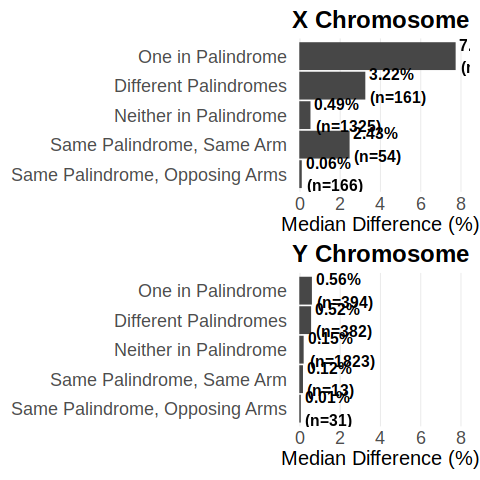

In [29]:
%%R
# plots
### PLOT 1 Pairwise differences palindrome categories ####

# Define order
palindrome_order <- c(
  'same_palindrome_opposing_arms',
  'same_palindrome_same_arm',
  'neither_in_palindrome',
  'different_palindromes',
  'one_in_palindrome'
)

# Define custom labels for categories
category_labels <- c(
  'same_palindrome_opposing_arms' = 'Same Palindrome, Opposing Arms',
  'same_palindrome_same_arm' = 'Same Palindrome, Same Arm',
  'neither_in_palindrome' = 'Neither in Palindrome',
  'different_palindromes' = 'Different Palindromes',
  'one_in_palindrome' = 'One in Palindrome'
)

# Function to prepare data
prepare_data <- function(df) {
  existing_categories <- palindrome_order[palindrome_order %in% unique(df$palindrome_relationship)]
  
  df %>%
    group_by(palindrome_relationship) %>%
    summarise(
      N_pairs = n(),
      Median_Percent_Diff = median(`pairwise_diff_%`, na.rm = TRUE),
      .groups = 'drop'
    ) %>%
    mutate(palindrome_relationship = factor(palindrome_relationship, levels = existing_categories)) %>%
    arrange(palindrome_relationship)
}

# Prepare data for both chromosomes
median_by_palindrome_x <- prepare_data(pairwise_x)
median_by_palindrome_y <- prepare_data(pairwise_y)

# Print summaries
print("X Chromosome - Median Percent Difference by Palindrome Category:")
print(median_by_palindrome_x)
print("\nY Chromosome - Median Percent Difference by Palindrome Category:")
print(median_by_palindrome_y)

# Function to create plot
create_plot <- function(data, title) {
  ggplot(data, aes(x = palindrome_relationship, y = Median_Percent_Diff)) +
    geom_bar(stat = "identity", 
             fill = "grey28",  # Grey bars
             color = "grey28", 
             linewidth = 0.6) +
    geom_text(aes(label = sprintf("%.2f%%\n(n=%d)", Median_Percent_Diff, N_pairs)),
              hjust = -0.1,
              fontface = "bold", 
              size = 5.5) +
    scale_x_discrete(labels = category_labels) +  # Use custom labels
    coord_flip() +
    labs(
      x = NULL,
      y = "Median Difference (%)",
      title = title
    ) +
    ylim(0,8)+
    theme_minimal() +
    theme(
      axis.title.y = element_blank(),
      axis.title.x = element_text(size = 20),
      axis.text.y = element_text(size = 18),
      axis.text.x = element_text(size = 18),
      plot.title = element_text(size = 24, face = "bold", hjust = 0.5),
      legend.position = "none",
      panel.grid.major.y = element_blank(),
      panel.grid.major.x = element_line(),
      panel.grid.minor = element_blank()
    )
}

# Create both plots
plot_x <- create_plot(median_by_palindrome_x, "X Chromosome")
plot_y <- create_plot(median_by_palindrome_y, "Y Chromosome")

# Combine plots vertically
combined_plot <- plot_x / plot_y

# Display the combined plot
print(combined_plot)

ggsave("sequences_x_full/GAGE_gene_conversion_Pairwise_differences_palindrome.pdf", combined_plot, width = 10, height = 8, units = "in")

# Calculate sample sizes for X chromosome
n_comparisons_x <- nrow(pairwise_x)
n_genes_x <- length(unique(c(pairwise_x$gene1, pairwise_x$gene2)))
n_species_x <- length(unique(pairwise_x$species))
n_families_x <- length(unique(pairwise_x$family))

cat("X Chromosome:\n")
cat(paste0("  ", n_comparisons_x, " pairwise comparisons\n"))
cat(paste0("  ", n_genes_x, " unique genes\n"))
cat(paste0("  ", n_families_x, " gene families across ", n_species_x, " species\n\n"))

# Calculate sample sizes for Y chromosome
n_comparisons_y <- nrow(pairwise_y)
n_genes_y <- length(unique(c(pairwise_y$gene1, pairwise_y$gene2)))
n_species_y <- length(unique(pairwise_y$species))
n_families_y <- length(unique(pairwise_y$family))

cat("Y Chromosome:\n")
cat(paste0("  ", n_comparisons_y, " pairwise comparisons\n"))
cat(paste0("  ", n_genes_y, " unique genes\n"))
cat(paste0("  ", n_families_y, " gene families across ", n_species_y, " species\n"))


In [28]:
%%R
### PLOT 3 Pairwise differences ~ copy number ####
# PLOT: All pairwise differences ~ copy number for GAGE family #
# Add copy number to each pairwise comparison
individual_pairwise <- pairwise_x %>%
  group_by(family, species, cluster) %>%
  mutate(copy_number = first(copy_number)) %>%  # Add copy number to each row
  ungroup()

# Filter for GAGE family
specific_family <- "GAGE12F"  

family_data <- individual_pairwise %>%
  filter(family == specific_family) %>%
  filter(copy_number > 1)  # remove copy number = 1

# Create scatter plot with regression line
plot2 <- ggplot(family_data, aes(x = copy_number, y = `pairwise_diff_%`)) +
  geom_point(alpha = 0.6, size = 3, position = position_jitter(width = 0.4, height = 0))+  # Reduced alpha since there will be overlapping points
  geom_smooth(method = "lm", 
              formula = y ~ x,
              se = T,
              color = "#3A87C4", 
              linetype = "dashed",
              linewidth = 1) +
  labs(
    x = "Copy Number",
    y = "Pairwise Difference (%)"
    #subtitle = paste0(n_comparisons, " pairwise comparisons across ", n_species, " species")
  ) +
  theme_minimal() +
  theme(
    axis.title = element_text(size = 12), #face = "bold"),
    axis.title.y = element_text(size=16),
    axis.title.x = element_text(size = 14),
    axis.text.y = element_text(size = 14),
    axis.text.x = element_text(size = 14),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.line = element_line(color = "black", linewidth = 0.5)
  )

plot2

# Calculate sample size info
n_comparisons <- nrow(family_data)
n_species <- length(unique(family_data$species))
n_clusters <- length(unique(family_data$cluster))

ggsave("sequences_x_full/GAGE_gene_conversion_Pairwise_differences_copynumber.pdf", plot2, width = 10, height = 8, units = "in")


In [30]:
%%R
### PLOT 4 Pairwise difference ~ absolute distance ####
## plot presentation
specific_family <- "GAGE12F"  

# Filter and convert to numeric
family_data <- pairwise_x %>%
  filter(family == specific_family) %>%
  mutate(
    absolute_distance_bp = as.numeric(absolute_distance_bp),
    pairwise_diff_percent = as.numeric(`pairwise_diff_%`),
    log_pairwise_diff = log10(pairwise_diff_percent + 0.1)
  ) %>%
  filter(!is.na(absolute_distance_bp), !is.na(pairwise_diff_percent)) %>%
  mutate(
    distance_bin = cut(absolute_distance_bp, 
                       breaks = quantile(absolute_distance_bp, probs = seq(0, 1, 0.2)),
                       include.lowest = TRUE)
  )

# Calculate mean distance for each quantile
bin_means <- family_data %>%
  group_by(distance_bin) %>%
  summarise(mean_dist = mean(absolute_distance_bp, na.rm = TRUE)) %>%
  mutate(
    mean_dist_formatted = format(round(mean_dist), big.mark = ",", scientific = FALSE),
    #new_label = paste0("Quantile ", 1:5, "\n(", mean_dist_formatted, " bp)")
    new_label = paste0("Q ", 1:5)
  )

# Apply new labels
family_data <- family_data %>%
  left_join(bin_means, by = "distance_bin") %>%
  mutate(distance_bin = factor(distance_bin, labels = bin_means$new_label))

# Create boxplot with regression line
plot3 <- ggplot(family_data, aes(x = distance_bin, y = log_pairwise_diff)) +
  geom_boxplot(alpha = 0.7) +
  geom_jitter(alpha = 0.3, size = 2.5, width = 0.2) +
  geom_smooth(aes(x = as.numeric(distance_bin), y = log_pairwise_diff),
              method = "lm", 
              formula = y ~ x,
              se = TRUE,
              color = "#3A87C4", 
              linetype = "dashed",
              linewidth = 1.4,
              inherit.aes = FALSE) +
  labs(x = "Absolute Distance (kb)",
       y = expression(log[10]~"(Pairwise Difference % + 0.1)")) +
  theme_minimal() +
  scale_x_discrete(labels = c("11-19 kb", 
                              "19-35 kb", 
                              "35-56 kb", 
                              "56-86 kb", 
                              "86-359 kb")) +
  theme(
    axis.title = element_text(size = 16),
    axis.text.x = element_text(size = 18),
    axis.title.y = element_text(size = 20),
    axis.title.x = element_text(size = 20),
    axis.text.y = element_text(size = 18),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.line = element_line(color = "black", linewidth = 1)
  )
plot3


ggsave("sequences_x_full/GAGE_gene_conversion_Pairwise_differences_absolutedistance.pdf", plot3, width = 10, height = 8, units = "in")


# Calculate sample size info
n_comparisons <- nrow(family_data)
n_species <- length(unique(family_data$species))
